# Computer Vision

## Torchvision 
- datasets
- models
- transforms

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch version : {torch.__version__}\ntorchvision version:{torchvision.__version__}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

PyTorch version : 1.13.1+cu116
torchvision version:0.14.1+cu116


In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torchinfo

In [6]:
import os, random
import numpy  as np
import pandas as pd

SEED = 42

def reset_seeds(seed):
    random.seed(seed) 
    # 파이썬 환경변수 시드 고정 
    os.environ[('PYTHONHASHSEED')] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

reset_seeds(SEED)


# Getting a dataset

In [9]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [12]:
image,label = train_data[0]

In [13]:
# 컬러 채널, 높이, 너비 
image.shape

torch.Size([1, 28, 28])

# EDA

In [14]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [16]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape : torch.Size([1, 28, 28])


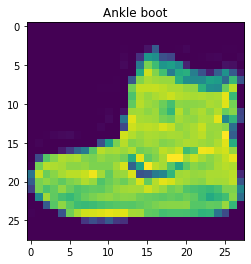

In [19]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f'Image shape : {image.shape}')

plt.imshow(image.squeeze())
plt.title(class_names[label]);

In [20]:
# squeeze로 필요없는색색 차원을 제거 (반대는 unsqueeze)
image.squeeze().shape, image.shape

(torch.Size([28, 28]), torch.Size([1, 28, 28]))

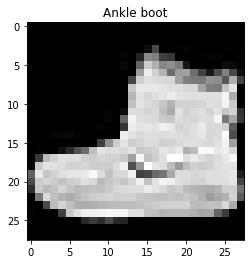

In [22]:
# 채널이 1이므로 흑백으로 보아야 형태가 잘 보인다. 
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label]);

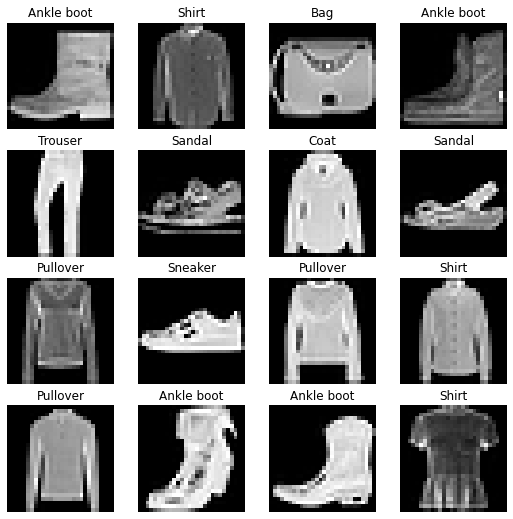

In [24]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1) :
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False);

# Prepare dataloader

In [25]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7faaa39f8040>, <torch.utils.data.dataloader.DataLoader object at 0x7faaa39caf40>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [30]:
c, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 0, label size: torch.Size([])


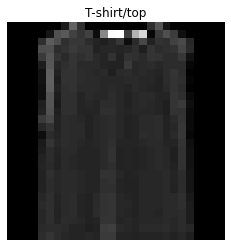

In [31]:
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");

print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

# CNN Model
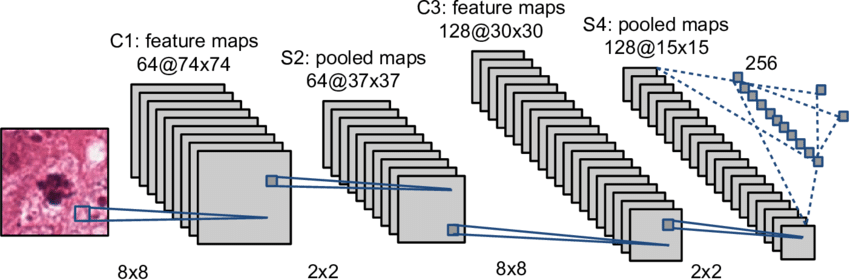

사진 데이터를 평면화 시키는 과정에서 공간 정보가 손실될 수밖에 없습니다. 결과적으로 이미지 공간 정보 유실로 인한 정보 부족으로 인공 신경망이 특징을 추출 및 학습이 비효율적이고 정확도를 높이는데 한계가 있습니다. 이미지의 공간 정보를 유지한 상태로 학습이 가능한 모델이 바로 CNN
(Convolutional Neural Network)

> output tensor size 
- O : size(width) of output image
- I : size(width) of input image
- K : size(width) of kernels used in the Conv layer
- N : number of kernals
- S : stride of the convolution opearation
- P : padding size

fully connected layer로 학습을 해야 함    
cnn은 필터를 이동시키면서 계산만 한다. 

In [32]:
m = nn.Conv2d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50, 100)
m(input).shape

torch.Size([20, 33, 24, 49])

## CNN model

In [ ]:
class CNNModel(nn.Module) :
    